# Otto商品分类——随机森林
原始特征+tfidf特征

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，分别调用缺省参数RandomFOrest、CART + GridSearchCV以进行参数调优。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


第一名：https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335
第二名：http://blog.kaggle.com/2015/06/09/otto-product-classification-winners-interview-2nd-place-alexander-guschin/

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

In [2]:
# 读取数据
# 这里使用原始特征+tf_idf特征，log(x+1)特征为原始特的单调变换，加上log特征对决策树模型影响不大
# path to where the data lies
dpath = './data/'

train1 = pd.read_csv(dpath +"Otto_FE_train_org.csv")
train2 = pd.read_csv(dpath +"Otto_FE_train_tfidf.csv")

#去掉多余的id
train2 = train2.drop(["id","target"], axis=1)
train =  pd.concat([train1, train2], axis = 1, ignore_index=False)
train.head()

del train1
del train2

## 准备数据

In [3]:
y_train = train['target']   
X_train = train.drop(["id", "target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可自行用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

## 默认参数的随机森林模型

In [6]:
from sklearn.ensemble import RandomForestClassifier
RF1 = RandomForestClassifier()

In [7]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
#数据集比较大，采用3折交叉验证
from sklearn.model_selection import cross_val_score
loss = cross_val_score(RF1, X_train, y_train, cv=3, scoring='neg_log_loss')
#%timeit loss_sparse = cross_val_score(lr, X_train_sparse, y_train, cv=3, scoring='neg_log_loss')
print ('logloss of each fold is: ',-loss)
print('cv logloss is:', -loss.mean())

logloss of each fold is:  [ 1.53925473  1.45269417  1.50612611]
cv logloss is: 1.49935833687


虽然结果还是不好，但比默认参数的单棵树性能还是好太多

## 随机森林超参数调优

随机森林的超参会有很多：
Bagging参数：
1. 树的数目n_estimators

与决策树的共同的超参数：
1. max_depth（树的深度）或max_leaf_nodes（叶子结点的数目）；
2. min_samples_leaf（叶子结点的最小样本数）、min_samples_split（中间结点的最小样本树）、min_weight_fraction_leaf（叶子节点的样本权重占总权重的比例）
3. max_features（最大特征数目）。与决策树max_features通常越大模型性能越好不同，随机森林中max_features较小，每个基学习器之间的相关性更小，集成模型的性能可能反而会更好；

另外在随机森林中，由于学习每个基学习器只用了一部分样本，可用其余样本（包外样本）做校验，从而不必显式进行交叉验证。
设置参数oob_score=True

#### n_estimators

In [13]:
#需要调优的参数
tuned_n_estimators = range(10,200,10)
accuracy_s = np.zeros(len(tuned_n_estimators))

#初始max_depth设为单棵树的max_depth，max_features比推荐值sqrt(D)=sqrt(186)=13略大,
#min_samples_leaf比单棵树的min_samples_leaf略小（详见CART参数调优）

for j, one_n_estimators in enumerate(tuned_n_estimators):
    RF2 = RandomForestClassifier(n_estimators = one_n_estimators, max_depth =10, max_features = 20, min_samples_leaf=30,oob_score=True,n_jobs=4,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_    

Text(0,0.5,u'accuracy')

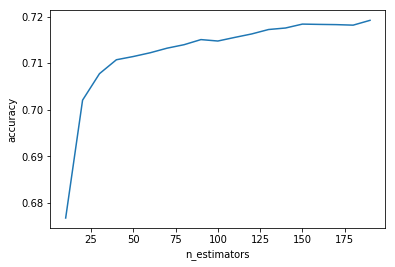

In [14]:
plt.plot(tuned_n_estimators, accuracy_s)
plt.xlabel( 'n_estimators' )                                                                                                      
plt.ylabel( 'accuracy' )

In [15]:
accuracy_s

array([ 0.67673487,  0.70205889,  0.7077475 ,  0.71073726,  0.71143217,
        0.71224021,  0.71322603,  0.71396942,  0.71506836,  0.7147613 ,
        0.71553702,  0.71628042,  0.71723391,  0.71755713,  0.71839749,
        0.71833285,  0.71828437,  0.71817124,  0.71920553])

模型性能随n_estimators增大趋势还在继续，扩大n_estimators

In [16]:
#需要调优的参数
tuned_n_estimators = range(200,400,10)
accuracy_s = np.zeros(len(tuned_n_estimators))

#初始max_depth设为单棵树的max_depth，max_features比推荐值sqrt(D)=sqrt(163)=13略大,
#min_samples_leaf比单棵树的min_samples_leaf略小

for j, one_n_estimators in enumerate(tuned_n_estimators):
    RF2 = RandomForestClassifier(n_estimators = one_n_estimators, max_depth =10, max_features = 20, min_samples_leaf=30,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_  

Text(0,0.5,u'accuracy')

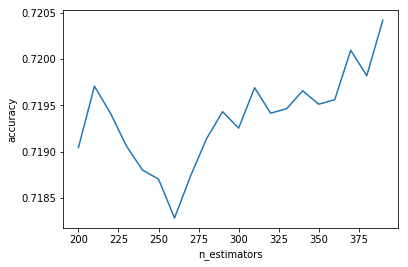

In [17]:
plt.plot(tuned_n_estimators, accuracy_s)
plt.xlabel( 'n_estimators' )                                                                                                      
plt.ylabel( 'accuracy' )

In [18]:
accuracy_s

array([ 0.71904393,  0.71970652,  0.71941562,  0.71906009,  0.71880151,
        0.71870455,  0.71828437,  0.71873687,  0.71914089,  0.71943179,
        0.71925402,  0.71969036,  0.71941562,  0.71946411,  0.71965804,
        0.71951259,  0.71956107,  0.72009438,  0.71981965,  0.7204176 ])

### n_estimators=200，调其他参数

### max_features

In [23]:
#需要调优的参数
tuned_parameters = range(10,40,2)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 200, max_features =one_parameter,oob_score=True,n_jobs=4,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_  

[ 0.81214648  0.81117683  0.81248586  0.81271211  0.81175862  0.81271211
  0.81300301  0.81337471  0.81352015  0.81208184  0.81301917  0.81208184
  0.81295452  0.81256666  0.81243738]


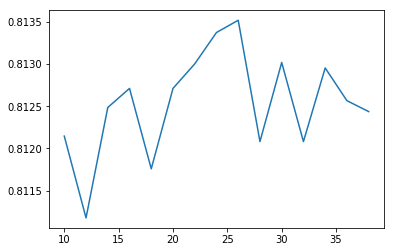

In [24]:
plt.plot(tuned_parameters, accuracy_s)
print(accuracy_s)

### max_features=26,模型性能抖动上升,无需细调

### max_depth

In [26]:
#需要调优的参数
tuned_parameters = range(10,50,10)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 200, max_features = 26, max_depth =one_parameter,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_  

[ 0.7254921   0.79394938  0.81103138  0.81424739]


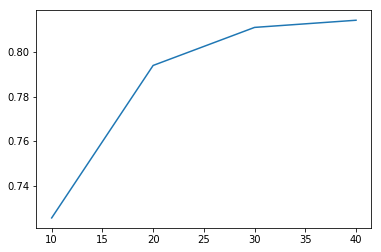

In [27]:
plt.plot(tuned_parameters, accuracy_s)
print(accuracy_s)

单调上升，继续扩大max_depth

In [28]:
#需要调优的参数
tuned_parameters = range(50,100,10)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 200, max_features = 26, max_depth =one_parameter,oob_score=True,n_jobs=4,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_  

[ 0.81227577  0.81269595  0.8132131   0.81352015  0.81352015]


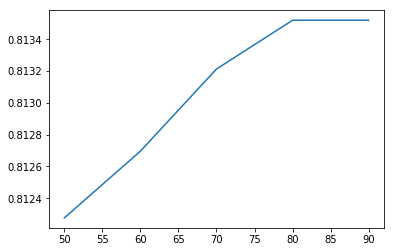

In [29]:
plt.plot(tuned_parameters, accuracy_s)
print(accuracy_s)

max_depth=40 和 max_depth=50之间的性能差异是由于随机性引起的？
重新一起运行试试。。。

In [30]:
#需要调优的参数
tuned_parameters = range(40,60,10)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 200, max_features = 26, max_depth =one_parameter,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_ 

In [31]:
print(accuracy_s)

[ 0.81424739  0.81227577]


### max_depth=40

### min_samples_leaf

In [32]:
#需要调优的参数
tuned_parameters = range(10,40,10)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 200, max_features = 26, max_depth =40, min_samples_leaf = one_parameter,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_ 
    print(accuracy_s[j])

0.792785804325
0.780471249879
0.773312001034


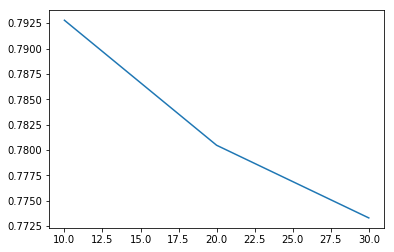

In [33]:
plt.plot(tuned_parameters, accuracy_s)

看来参数值太大了

In [34]:
#需要调优的参数
tuned_parameters = range(1,10,2)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 200, max_features = 26, max_depth =40, min_samples_leaf = one_parameter,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(X_train, y_train)
    accuracy_s[j] = RF2.oob_score_ 
    print(accuracy_s[j])

0.814247390026
0.806845728692
0.802692394712
0.797246194124
0.794353405087


CART其他模型复杂度参数：
1. max_leaf_nodes和max_depth类似，调试其中任意一个就好；
2. min_samples_split和min_samples_leaf通常也有关系，调试其中任意一个就好；
3. min_weight_fraction_leaf：由于本任务我们对类别/样本没有设置权重，min_weight_fraction_leaf和min_samples_leaf通常也有关系功能类似，也无需调整。

当然如果有计算资源，对上述参数进行调优也可以，只是预计再调优得到的性能提升不大。

### 用最佳参数组合，训练模型

In [36]:
RF2 = RandomForestClassifier(n_estimators = 200, max_features = 26, max_depth =40, min_samples_leaf = 1,n_jobs=4,random_state=33)
RF2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=26, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=33, verbose=0, warm_start=False)

## 保存模型，用于后续测试

In [37]:
import cPickle

cPickle.dump(RF2, open("Otto_RF_org_tfidf.pkl", 'wb'))

### 特征重要性

In [38]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(RF2.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [39]:
df

,columns,importance
132,feat_40_tfidf,0.035621
126,feat_34_tfidf,0.032133
103,feat_11_tfidf,0.030106
106,feat_14_tfidf,0.029846
10,feat_11,0.028945
152,feat_60_tfidf,0.026627
59,feat_60,0.023426
33,feat_34,0.022730
107,feat_15_tfidf,0.022679
118,feat_26_tfidf,0.020869


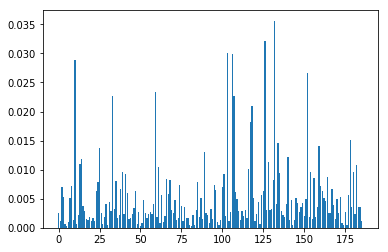

In [40]:
plt.bar(range(len(RF2.feature_importances_)), RF2.feature_importances_)
plt.show()

不同特征之间的重要性差异没那么大，可解释性减弱。

### 随机森林的概率校准
诸如bagging 和 random forests（随机森林）的方法， 从基本模型的平均预测中可能难以将预测置于 0 和 1 附近，因此对其结果输出做概率校准，得到的每类概率输出会更好。

In [42]:
from sklearn.calibration import CalibratedClassifierCV

CalibratedRF = CalibratedClassifierCV(base_estimator=RF2, cv=5)
CalibratedRF.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=26, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=33, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

## 保存模型，用于后续测试

In [45]:
import cPickle

cPickle.dump(CalibratedRF, open("Otto_CalibratedRF_org_tfidf.pkl", 'wb'))